# Problem 2: MNIST: Hand-written digit classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [ ]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, 
                                                             [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)], 
                                                             generator=torch.Generator().manual_seed(42))
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target):

In [ ]:
print(len(train_dataset), len(valid_dataset), len(test_dataset), type(train_dataset[0][0]), type(train_dataset[0][1]))

48000 12000 10000 <class 'torch.Tensor'> <class 'int'>


We can convert images to numpy arrays and plot them with matplotlib:

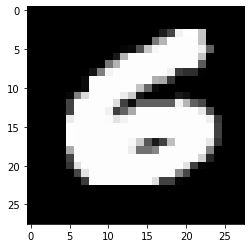

In [ ]:
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

## Example linear model
Let's instantiate a linear model and take a look at the layers.

In [ ]:
model = nn.Sequential(
    # For fully-connected networks, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 10),
)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


## Training and validation

Now let's try to train the linear model as an example.

In [ ]:
def run_training_loop(model, batch_size=32, n_epochs=10, lr=1e-3):

    # We could write our training procedure manually and directly index the `Dataset` objects,
    # but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # Choose Adam as the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # store metrics
    train_loss_history = np.zeros([n_epochs, 1])
    valid_accuracy_history = np.zeros([n_epochs, 1])
    valid_loss_history = np.zeros([n_epochs, 1])

    for epoch in range(n_epochs):

        # Some layers, such as Dropout, behave differently during training
        model.train()

        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = loss_fn(output, target)
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            
            # Weight update
            optimizer.step()

        train_loss_history[epoch] = train_loss / len(train_loader.dataset)

        # Track loss each epoch
        print('Train Epoch: %d  Average loss: %.4f' %
              (epoch + 1,  train_loss_history[epoch]))

        # Putting layers like Dropout into evaluation mode
        model.eval()

        valid_loss = 0
        correct = 0

        # Turning off automatic differentiation
        with torch.no_grad():
            for data, target in valid_loader:
                output = model(data)
                valid_loss += loss_fn(output, target).item()  # Sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
                correct += pred.eq(target.view_as(pred)).sum().item()

        valid_loss_history[epoch] = valid_loss / len(valid_loader.dataset)
        valid_accuracy_history[epoch] = correct / len(valid_loader.dataset)

        print('Valid set: Average loss: %.4f, Accuracy: %d/%d (%.4f)\n' %
              (valid_loss_history[epoch], correct, len(valid_loader.dataset),
              100. * valid_accuracy_history[epoch]))
    
    return model, train_loss_history, valid_loss_history, valid_accuracy_history

Train Epoch: 1  Average loss: 0.0155
Valid set: Average loss: 0.0107, Accuracy: 10876/12000 (90.6333)

Train Epoch: 2  Average loss: 0.0097
Valid set: Average loss: 0.0099, Accuracy: 10929/12000 (91.0750)

Train Epoch: 3  Average loss: 0.0089
Valid set: Average loss: 0.0094, Accuracy: 10977/12000 (91.4750)

Train Epoch: 4  Average loss: 0.0085
Valid set: Average loss: 0.0094, Accuracy: 11009/12000 (91.7417)

Train Epoch: 5  Average loss: 0.0083
Valid set: Average loss: 0.0093, Accuracy: 10990/12000 (91.5833)

Train Epoch: 6  Average loss: 0.0081
Valid set: Average loss: 0.0094, Accuracy: 10974/12000 (91.4500)

Train Epoch: 7  Average loss: 0.0080
Valid set: Average loss: 0.0093, Accuracy: 10999/12000 (91.6583)

Train Epoch: 8  Average loss: 0.0079
Valid set: Average loss: 0.0092, Accuracy: 11031/12000 (91.9250)

Train Epoch: 9  Average loss: 0.0078
Valid set: Average loss: 0.0092, Accuracy: 11050/12000 (92.0833)

Train Epoch: 10  Average loss: 0.0077
Valid set: Average loss: 0.0092, Ac

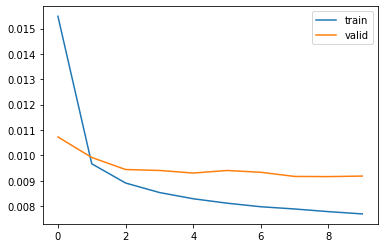

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

## Testing
After selecting hyperparameters from the validation set, evaluate on the held-out test set (distinct from the validation set).

In [ ]:
def test_performance(model, batch_size=32):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

    # Putting layers like Dropout into evaluation mode
    model.eval()
    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    test_loss = 0
    correct = 0

    # Turning off automatic differentiation
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
          (test_loss, correct, len(test_loader.dataset),
          100. * test_accuracy))
    return test_loss, test_accuracy

In [ ]:
test_performance(model)

Test set: Average loss: 0.0084, Accuracy: 9261/10000 (92.6100)


(0.008421745701879263, 0.9261)

Not bad! Even the linear model gets above 92% accuracy.

## Visualizing predictions

We can visualize and inspect the model predictions. Here is an example of how to visualize the wrongly classified cases among the first 20 validation examples.

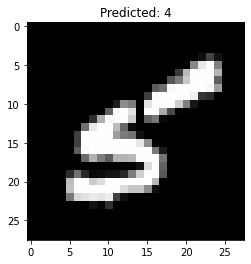

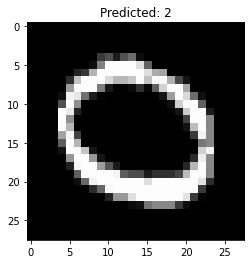

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

# Turning off automatic differentiation
with torch.no_grad():
      for i in range(20):
        data, target = valid_dataset[i]
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        if pred.item() != target:
            plt.imshow(data[0].numpy(), cmap='gray')
            plt.title(f'Predicted: {pred.item()}')
            plt.show()

# Your code: 2 (b)

In [ ]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(100, 10)
)


Train Epoch: 1  Average loss: 0.0108
Valid set: Average loss: 0.0054, Accuracy: 11359/12000 (94.6583)

Train Epoch: 2  Average loss: 0.0047
Valid set: Average loss: 0.0038, Accuracy: 11539/12000 (96.1583)

Train Epoch: 3  Average loss: 0.0036
Valid set: Average loss: 0.0034, Accuracy: 11604/12000 (96.7000)

Train Epoch: 4  Average loss: 0.0028
Valid set: Average loss: 0.0033, Accuracy: 11622/12000 (96.8500)

Train Epoch: 5  Average loss: 0.0024
Valid set: Average loss: 0.0031, Accuracy: 11646/12000 (97.0500)

Train Epoch: 6  Average loss: 0.0021
Valid set: Average loss: 0.0031, Accuracy: 11672/12000 (97.2667)

Train Epoch: 7  Average loss: 0.0019
Valid set: Average loss: 0.0028, Accuracy: 11684/12000 (97.3667)

Train Epoch: 8  Average loss: 0.0018
Valid set: Average loss: 0.0030, Accuracy: 11679/12000 (97.3250)

Train Epoch: 9  Average loss: 0.0015
Valid set: Average loss: 0.0030, Accuracy: 11692/12000 (97.4333)

Train Epoch: 10  Average loss: 0.0014
Valid set: Average loss: 0.0030, Ac

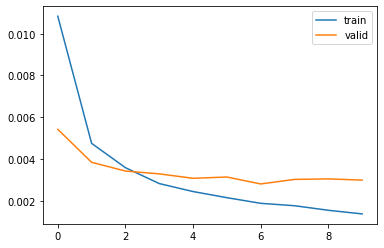

Test set: Average loss: 0.0025, Accuracy: 9753/10000 (97.5300)


(0.0025156809893604076, 0.9753)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

What to expect:
Training for 10 epochs takes a few minutes
- Starter code: accuracy 92.5%
- Tuning down dropout to 0.1: accuracy 95.7%
- Increasing width to 100 (still one layer): accuracy 97.7%
- Adding a second hidden layer with width 100: accuracy 97.9%

# Example code for convolutional neural networks

In [ ]:
# sample model
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(8,8)),
    nn.ReLU(),
    nn.MaxPool2d(8),
    nn.Dropout(p=0.5),
    
    nn.Flatten(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
)

# take a look at the shape of the weights for each layer
for p in model.parameters():
    print(p.data.shape)


# our model has some # of parameters:
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

torch.Size([8, 1, 8, 8])
torch.Size([8])
torch.Size([64, 32])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
total params: 3282


Train Epoch: 1  Average loss: 0.0376
Valid set: Average loss: 0.0171, Accuracy: 10308/12000 (85.9000)

Train Epoch: 2  Average loss: 0.0257
Valid set: Average loss: 0.0128, Accuracy: 10758/12000 (89.6500)

Train Epoch: 3  Average loss: 0.0232
Valid set: Average loss: 0.0116, Accuracy: 10871/12000 (90.5917)

Train Epoch: 4  Average loss: 0.0219
Valid set: Average loss: 0.0100, Accuracy: 10954/12000 (91.2833)

Train Epoch: 5  Average loss: 0.0207
Valid set: Average loss: 0.0098, Accuracy: 10974/12000 (91.4500)

Train Epoch: 6  Average loss: 0.0202
Valid set: Average loss: 0.0091, Accuracy: 11095/12000 (92.4583)

Train Epoch: 7  Average loss: 0.0196
Valid set: Average loss: 0.0090, Accuracy: 11050/12000 (92.0833)

Train Epoch: 8  Average loss: 0.0190
Valid set: Average loss: 0.0089, Accuracy: 11052/12000 (92.1000)

Train Epoch: 9  Average loss: 0.0188
Valid set: Average loss: 0.0088, Accuracy: 11081/12000 (92.3417)

Train Epoch: 10  Average loss: 0.0182
Valid set: Average loss: 0.0089, Ac

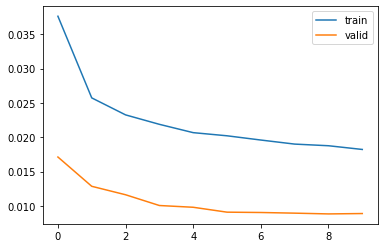

Test set: Average loss: 0.0085, Accuracy: 9230/10000 (92.3000)


(0.00850779461711645, 0.923)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

## Your code: 2 (c)

In [ ]:
model_conv = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(5, 5)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 8, kernel_size=(5, 5)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.Conv2d(8, 8, kernel_size=(5, 5)),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    nn.MaxPool2d(8, stride=4),
    nn.Dropout(p=0.2),
)

model_ff = nn.Sequential(
    nn.Flatten(),
    nn.Linear(8 * 3 * 3, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

model = nn.Sequential(
    model_conv,
    model_ff
)

# make sure the # of parameters is under half a million
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

total params: 8794


Train Epoch: 1  Average loss: 0.0109
Valid set: Average loss: 0.0037, Accuracy: 11552/12000 (96.2667)

Train Epoch: 2  Average loss: 0.0045
Valid set: Average loss: 0.0028, Accuracy: 11666/12000 (97.2167)

Train Epoch: 3  Average loss: 0.0036
Valid set: Average loss: 0.0023, Accuracy: 11722/12000 (97.6833)

Train Epoch: 4  Average loss: 0.0032
Valid set: Average loss: 0.0021, Accuracy: 11741/12000 (97.8417)

Train Epoch: 5  Average loss: 0.0028
Valid set: Average loss: 0.0019, Accuracy: 11775/12000 (98.1250)

Train Epoch: 6  Average loss: 0.0026
Valid set: Average loss: 0.0018, Accuracy: 11788/12000 (98.2333)

Train Epoch: 7  Average loss: 0.0024
Valid set: Average loss: 0.0020, Accuracy: 11777/12000 (98.1417)

Train Epoch: 8  Average loss: 0.0023
Valid set: Average loss: 0.0017, Accuracy: 11806/12000 (98.3833)

Train Epoch: 9  Average loss: 0.0022
Valid set: Average loss: 0.0017, Accuracy: 11790/12000 (98.2500)

Train Epoch: 10  Average loss: 0.0021
Valid set: Average loss: 0.0016, Ac

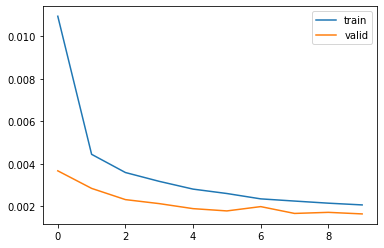

Test set: Average loss: 0.0012, Accuracy: 9878/10000 (98.7800)


(0.0012071133732271847, 0.9878)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

# Problem 3: Vision Transformer

In [ ]:
!pip install einops

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

## Your code: 3(a)

Implement single-head attention.

In [ ]:
class SingleHeadAttention(nn.Module):
    def __init__(self, input_dim, inner_dim, dropout = 0.):
        super().__init__()
        # TODO
        self.q = nn.Linear(input_dim, inner_dim)
        self.k = nn.Linear(input_dim, inner_dim)
        self.v = nn.Linear(input_dim, inner_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.softmax = nn.Softmax(dim=-1)
        self.d_k = inner_dim

    def forward(self, x):
        # TODO
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)

        attn_weights = self.softmax(torch.matmul(Q, torch.transpose(K, -2, -1)) / np.sqrt(self.d_k))
        out = torch.matmul(attn_weights, V)
        
        out = self.dropout(out)

        return out, attn_weights  # modification for attention visualization

Test the following multihead attention implementation that relies on the single-head attention implementation above.

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        self.attention_heads = nn.ModuleList([
            SingleHeadAttention(dim, dim_head, dropout=dropout)
            for _ in range(heads)
        ])

    def forward(self, x):
        # modification for attention visualization
        outputs = [head(x) for head in self.attention_heads]
        out = torch.cat([o[0] for o in outputs], dim=-1)
        attn_weights = torch.stack([o[1] for o in outputs])
        return out, attn_weights

Test code for multihead attention:

In [ ]:
T = 5
input_dim = 32
batch_size = 20

heads = 8
dim_head = 64

test_input = torch.zeros((batch_size, T, input_dim))

test_attention_module = Attention(input_dim)
test_output, test_attn_weights = test_attention_module(test_input)

print(test_output)
assert test_output.size() == (batch_size, T, heads * dim_head), "Shapes are incorrect"

tensor([[[ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593]],

        [[ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593]],

        [[ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
         [ 0.0708,  0.1007,  0.0581,  ...,  0.1649, -0.1065,  0.0593],
  

In [ ]:
test_attn_weights.size()

torch.Size([8, 20, 5, 5])

## Your code: 3 (b)

In [ ]:
class ViTLayer(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        # modification for attention visualization
        self.layernorm = nn.LayerNorm(dim)
        self.attn_proj = nn.Linear(dim_head * heads, dim)
        self.attn = Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)
        self.feedforward = nn.Sequential(
                nn.LayerNorm(dim),
                nn.Linear(dim, mlp_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(mlp_dim, dim),
                nn.Dropout(dropout)
        )

    def forward(self, x, *args):
        dx, attn_weights = self.attn(self.layernorm(x))
        x = x + self.attn_proj(dx)
        x = self.feedforward(x) + x
        return x, attn_weights


# ViT code for 3 (c)

In [ ]:
class ViT(nn.Module):
    def __init__(self, patch_size=7, dim=64, depth=6, heads=8, mlp_dim=128, 
                 dim_head = 64,
                 dropout = 0., emb_dropout = 0.):
        super().__init__()

        image_height, image_width = 28, 28
        num_classes = 10
        channels = 1

        patch_height = patch_size
        patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, (
            'Image dimensions must be divisible by the patch size.')

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.emb_dropout = nn.Dropout(emb_dropout)

        self.transformer_layers = nn.ModuleList([
            ViTLayer(dim, heads, dim_head, mlp_dim, dropout)
            for _ in range(depth)                       
        ])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img, return_attn_weights=False):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.emb_dropout(x)

        for layer in self.transformer_layers:
          x, attn_weights = layer(x)

        x = x[:, 0]
        if return_attn_weights:
          return self.mlp_head(x), attn_weights
        else:
          return self.mlp_head(x)

In [ ]:
test = ViTLayer(32, 8, 64, 64)
test(torch.zeros((1, 32)))

(tensor([[-0.1842, -0.1639, -0.5239,  0.1584,  0.3175,  0.2925,  0.1613, -0.3884,
          -0.0655,  0.1032,  0.4625,  0.0320, -0.2111, -0.5513, -0.1455,  0.0119,
          -0.1305,  0.1362,  0.0932,  0.1014,  0.0137, -0.0074,  0.1792, -0.2867,
          -0.0661, -0.2796,  0.3848,  0.2585, -0.3435, -0.4002,  0.0737, -0.1013]],
        grad_fn=<AddBackward0>), tensor([[[1.]],
 
         [[1.]],
 
         [[1.]],
 
         [[1.]],
 
         [[1.]],
 
         [[1.]],
 
         [[1.]],
 
         [[1.]]], grad_fn=<StackBackward0>))

In [ ]:
model = ViT(patch_size=7, dim=64, depth=6, heads=8, mlp_dim=128)

Train Epoch: 1  Average loss: 0.0106
Valid set: Average loss: 0.0064, Accuracy: 11208/12000 (93.4000)

Train Epoch: 2  Average loss: 0.0044
Valid set: Average loss: 0.0062, Accuracy: 11296/12000 (94.1333)

Train Epoch: 3  Average loss: 0.0035
Valid set: Average loss: 0.0034, Accuracy: 11609/12000 (96.7417)

Train Epoch: 4  Average loss: 0.0028
Valid set: Average loss: 0.0038, Accuracy: 11548/12000 (96.2333)

Train Epoch: 5  Average loss: 0.0025
Valid set: Average loss: 0.0029, Accuracy: 11671/12000 (97.2583)

Train Epoch: 6  Average loss: 0.0022
Valid set: Average loss: 0.0028, Accuracy: 11654/12000 (97.1167)

Train Epoch: 7  Average loss: 0.0021
Valid set: Average loss: 0.0027, Accuracy: 11688/12000 (97.4000)

Train Epoch: 8  Average loss: 0.0017
Valid set: Average loss: 0.0024, Accuracy: 11729/12000 (97.7417)

Train Epoch: 9  Average loss: 0.0016
Valid set: Average loss: 0.0026, Accuracy: 11689/12000 (97.4083)

Train Epoch: 10  Average loss: 0.0015
Valid set: Average loss: 0.0024, Ac

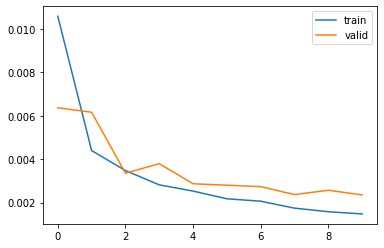

Test set: Average loss: 0.0021, Accuracy: 9798/10000 (97.9800)


(0.002103428775811335, 0.9798)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model, n_epochs=10)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

In [ ]:
# Turning off automatic differentiation

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

# Putting layers like Dropout into evaluation mode
model.eval()


with torch.no_grad():
    for data, target in test_loader:
        output, attn_weights = model(data, return_attn_weights=True)
        break

In [ ]:
attn_weights.shape

torch.Size([8, 20, 17, 17])

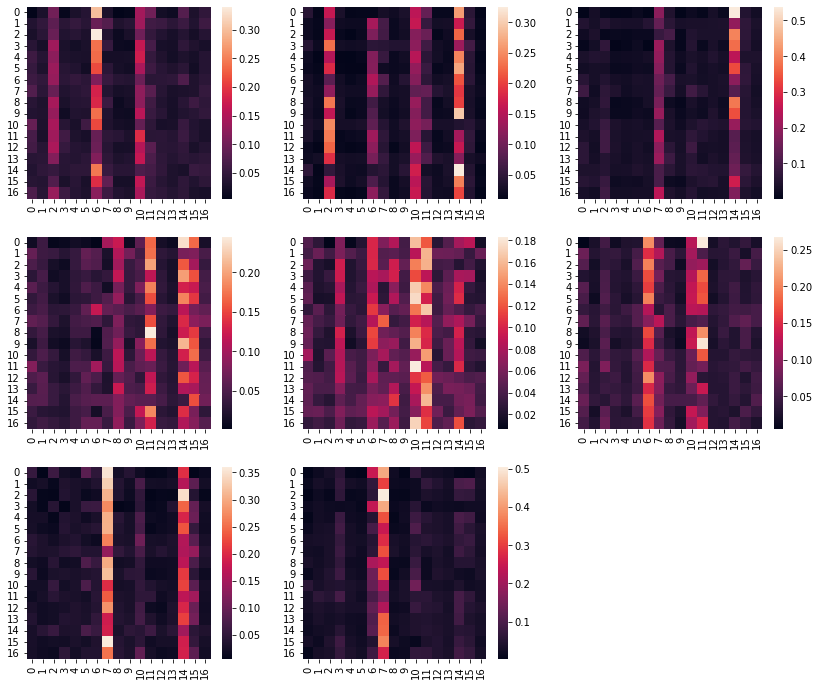

In [ ]:
import seaborn as sns
fig, axes = plt.subplots(3, 3, figsize=(14,12))
for i in range(8):
    sns.heatmap(torch.mean(attn_weights[i], dim=0), ax=axes.flatten()[i])
axes[-1, -1].axis('off')
plt.show()